In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
path = '/content/gdrive/MyDrive/Colab Notebooks/TrackNet/Code_Python3/TrackNet_Three_Frames_Input/'
os.chdir(path)
!pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/TrackNet/Code_Python3/TrackNet_Three_Frames_Input


In [ ]:
!pip3 install filterpy sktime piexif imutils Pillow

     |████████████████████████████████| 177 kB 9.6 MB/s 
     |████████████████████████████████| 6.6 MB 51.0 MB/s 
     |████████████████████████████████| 9.8 MB 45.3 MB/s 
     |████████████████████████████████| 3.3 MB 40.7 MB/s 
     |████████████████████████████████| 34.5 MB 7.1 kB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=1af847a6bc89378f43fd943bb2f0ead36fb602a9794cf008ac2e2150016fe072
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uni

In [ ]:
input_video = "\'/content/gdrive/MyDrive/Colab Notebooks/tennis-tracking/VideoInput/golpes_TCTS.mp4\'"
output_video = "\'/content/gdrive/MyDrive/Colab Notebooks/tennis-tracking/VideoInput/FinalQatar_PremierPadel_Trim_TN.mp4\'"
! python3 predict_video.py  --save_weights_path=weights/model.3 --input_video_path={input_video} --output_video_path={output_video} --n_classes=256


In [ ]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/TrackNet/Code_Python3/TrackNet_Three_Frames_Input


In [3]:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
from keras.preprocessing import image

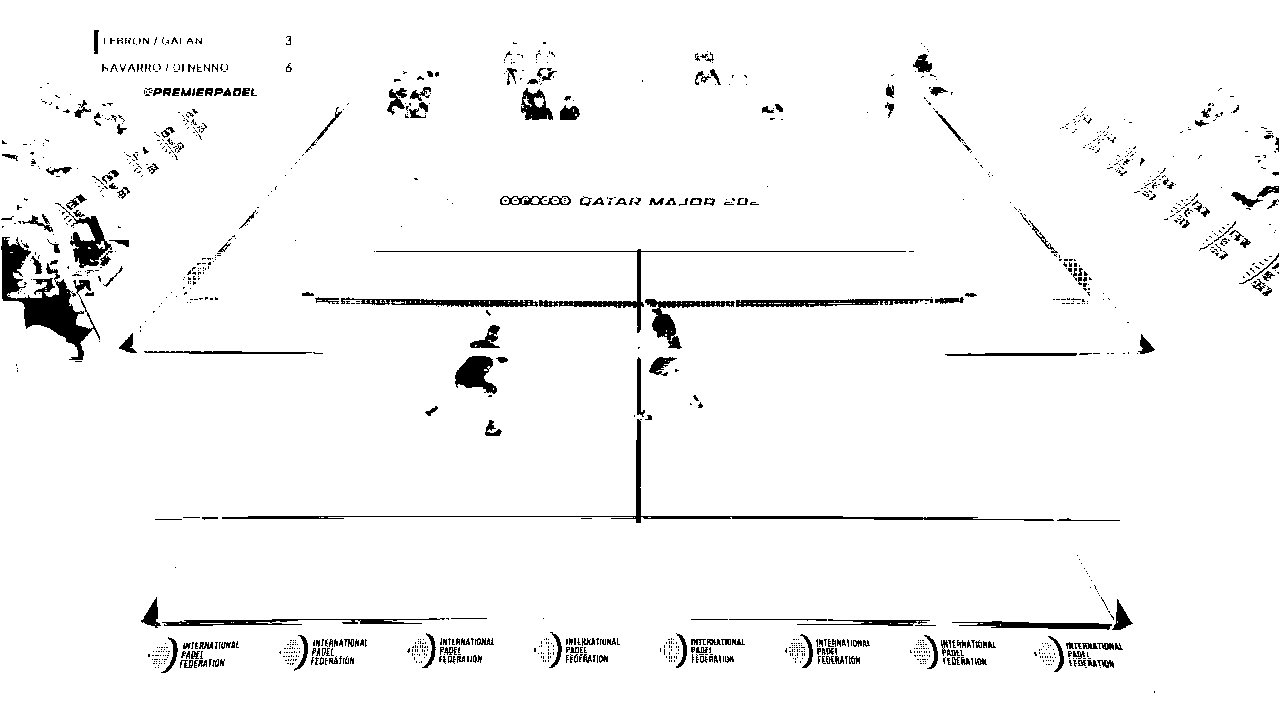

In [56]:
# Create a list to store the urls of the images

# Read and display the image
# loop over the image URLs, you could store several image urls in the list

img_path =  '/content/gdrive/MyDrive/PadelData/Pista/padel_court.jpg'
img = io.imread(img_path,0) 
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = image.img_to_array(img, dtype='uint8')
thresh, img_bin = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)
 
final_frame = img_bin
cv2_imshow(final_frame)


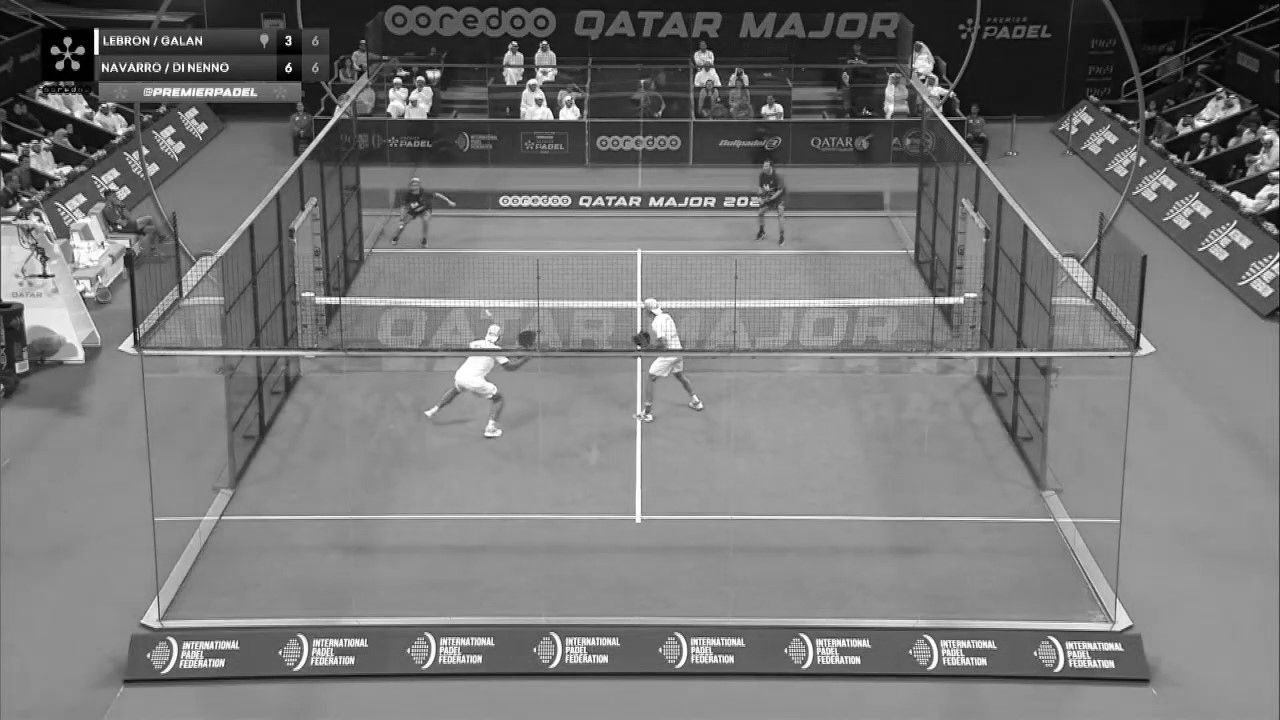

[[637, 251, 637, 522, 6], [1, 218, 1, 296, 0]]


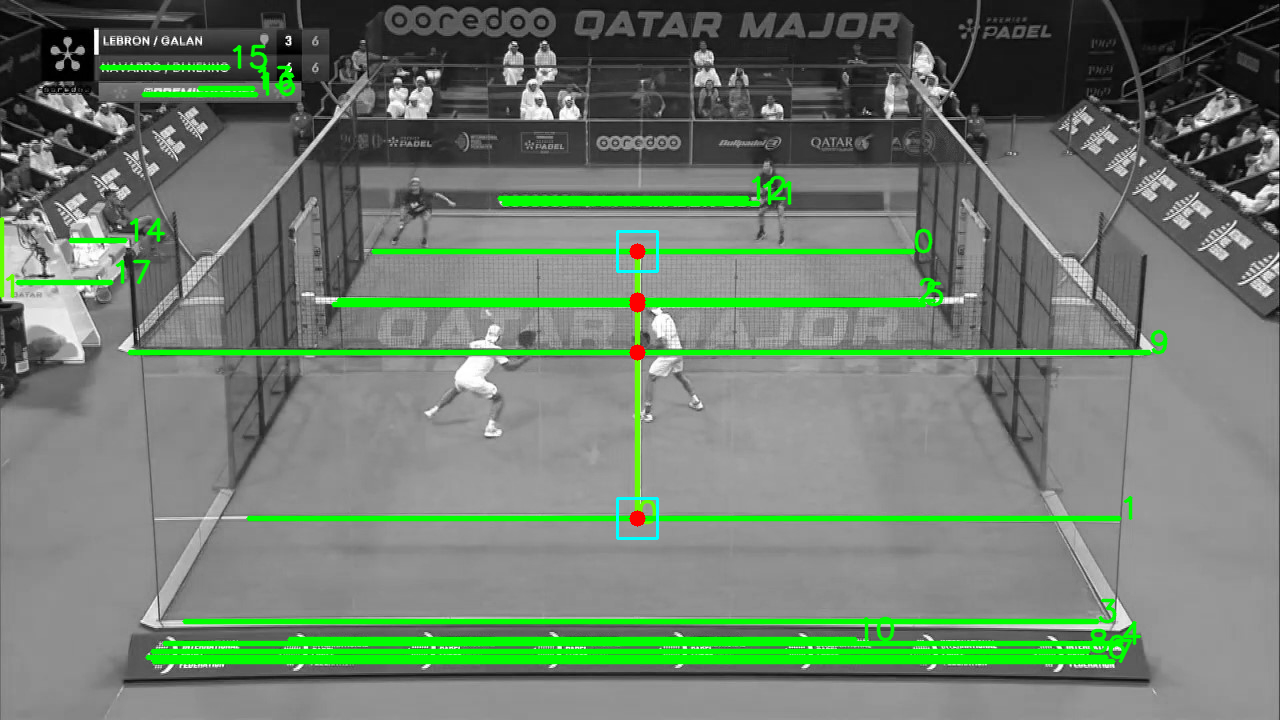

In [63]:
import math

t_points = [[637, 251], [637, 518], 25]


def avg(lst):
    return sum(lst)/len(lst)

def group_similar_lines(lines, v_h = 0):
  res_lines = []
  for l in lines:
    dist = [[abs((l[0+v_h]+l[2+v_h])/2 - avg([(s[0+v_h]+s[2+v_h])/2 for s in res_lines[i]])) , i] for i in range(len(res_lines))]
    if dist != []:
      dist.sort(key=lambda a: a[0])
      if dist[0][0] < 5:
        res_lines[dist[0][1]].append(l)
      else:
        res_lines.append([l])
    else:
      res_lines.append([l])
  res = []
  for g in res_lines:
    x = int(round(avg([(l[0+v_h]+l[2+v_h])/2 for l in g]), 0))
    width = max([max(l[0+v_h],l[2+v_h]) for l in g]) - min([min(l[0+v_h],l[2+v_h]) for l in g])   
    y_min = int(round(min([min([l[1-v_h],l[3-v_h]]) for l in g]), 0))
    y_max = int(round(max([max([l[1-v_h],l[3-v_h]]) for l in g]), 0))
    if v_h==0: #vertical line
      res.append([x, y_min, x, y_max, width])
    else: #horizontal line
      res.append([y_min, x, y_max, x, width])
  return res


def line_intersection_vh(line_v, line_h):
    if line_v[0] <= max(line_h[0], line_h[2]) and \
        line_v[0] >= min(line_h[0], line_h[2]) and \
        line_h[1] <= max(line_v[1], line_v[3]) and \
        line_h[1] >= min(line_v[1], line_v[3]):
      return [line_v[0], line_h[1]]
    return None

dst = cv.Canny(final_frame, 50, 200, None, 3)
   
# Copy edges to the images that will display the results in BGR
cdst = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)
cv2_imshow( cdstP)
    
lines = cv.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)
    
if lines is not None:
  for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv.line(cdst, pt1, pt2, (0,255,0), 3, cv.LINE_AA)
    
    
linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)
instersection = []
if linesP is not None:
  h_lines = [l[0] for l in linesP if abs(l[0][1]-l[0][3])<3]
  v_lines = [l[0] for l in linesP if abs(l[0][0]-l[0][2])<3]
  
  v_lines = group_similar_lines(v_lines)
  h_lines = group_similar_lines(h_lines, 1)
  print(v_lines)
  for v in v_lines:
    for h in h_lines:
      instersection.append(line_intersection_vh(v, h))
  instersection = [i for i in instersection if i]
  for i in range(0, len(v_lines)):
    #print(linesP[i])
    l = v_lines[i]
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,255,100), 3, cv.LINE_AA)
    cv.putText(cdstP, str(i), (l[2], l[3]), cv.FONT_HERSHEY_SIMPLEX, 1, (0,255,100), 2, cv.LINE_AA)
  for i in range(0, len(h_lines)):
    #print(linesP[i])
    l = h_lines[i]
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,255,0), 3, cv.LINE_AA)
    cv.putText(cdstP, str(i), (l[2], l[3]), cv.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv.LINE_AA)
  for p in instersection:
    cdstP = cv.circle(cdstP, (int(p[0]), int(p[1])), 8, (0,0,255), -1)
  
  cdstP = cv.rectangle(cdstP, (t_points[0][0]+t_points[2], t_points[0][1]+t_points[2]), \
                       (t_points[0][0]-t_points[2], t_points[0][1]-t_points[2]), (255, 255, 0), 2)
  cdstP = cv.rectangle(cdstP, (t_points[1][0]+t_points[2], t_points[1][1]+t_points[2]), \
                       (t_points[1][0]-t_points[2], t_points[1][1]-t_points[2]), (255, 255, 0), 2)
    
#cv2_imshow(img)
#cv2_imshow(cdst)
cv2_imshow(cdstP)